##인간보다 퀴즈를 잘푸는 인공지능

개발 환경
<br/>데이터 정보


데이터 전처리
<br/>띄어쓰기 단위 정보관리
<br/>Subword Segmentation
<br/>정답 토큰 범위
<br/>데이터 분리

데이터 탐색
<br/>Histogram. Box Plot
<br/>Wordcloud

데이터 로더

모델 구성

Position Embedding
<br/>Masked
<br/>Shared Embedding
<br/>MultiHead Attention
<br/>Position Wise Feed Forward
<br/>Encoder Layer

BERT
<br/>Non Pretrained Model
<br/>Pretrained Model

모델 학습
<br/>인퍼런스
<br/>모델 평가
<br/>결론
<br/>참고문헌

# 개발 환경

In [ ]:
!pip install tensorflow-addons

In [ ]:
!pip install sentencepiece

In [ ]:
import os
from importlib_metadata import version
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
import pickle
import json

In [ ]:
import pandas as pd
import numpy as np
import collections
from datetime import datetime
from tqdm.notebook import tqdm

In [ ]:
import tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

In [ ]:
import re
import sentencepiece as spm
from wordcloud import WordCloud

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import random
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['importlib-metadata', 'future', 'pickle', 'json', 'pandas=', 'numpy=', 
                'collections', 'date', 'tensorflow=', 'sentencepiece', 'tqdm', 'keras',
                'addons', 'tensorflow.keras', 'matplotlib=', 'seaborn=']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

cloudpickle==1.3.0      convertdate==2.4.0      fastjsonschema==2.15.3     
future==0.16.0      importlib-metadata==4.11.4      jsonschema==4.3.3     
keras==2.8.0      keras-vis==0.4.1      matplotlib==3.2.2     
numpy==1.21.6      pandas==1.3.5      pickleshare==0.7.5     
python-dateutil==2.8.2      seaborn==0.11.2      sentencepiece==0.1.96     
sklearn-pandas==1.8.0      tensorflow==2.8.2+zzzcolab20220527125636      tensorflow-addons==0.17.1     
tqdm==4.64.0     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#데이터 정보

[KorQuAD 1.0](https://korquad.github.io/KorQuad%201.0/)

한국어 Machine Reading Comprehension을 위해 만든 데이터셋이다.

모든 질의에 대한 답변은 해당 Wikipedia article 문단의 일부 하위 영역으로 이루어진다.
<br/>Stanford Question Answering Dataset(SQuAD) v1.0과 동일한 방식으로 구성되었다.

In [ ]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

 KorQuAD 데이터처럼 json 포맷으로 이루어진 데이터에서
 <br/>list의 첫 번째 item의 실제 내용을 간단히 확인한다.

In [ ]:
data_dir = '/content/drive/MyDrive/lms/bert_qna/data'
model_dir = '/content/drive/MyDrive/lms/bert_qna/model'

train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [ ]:
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


훈련데이터와 검증데이터를 확인한다.

In [ ]:
print(json.dumps(train_json["data"][0]["paragraphs"][0]["qas"][0], indent=2, ensure_ascii=False))

{
  "answers": [
    {
      "text": "교향곡",
      "answer_start": 54
    }
  ],
  "id": "6566495-0-0",
  "question": "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?"
}


#데이터 전처리

##띄어쓰기 단위 정보관리

In [ ]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [ ]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

SQuAD 유형의 문제를 풀 때 글자 혹은 subword 단위로 token이 분리되는 것에 대비해서
<br/>데이터가 띄어쓰기 단위로 어떠했었는지 word token 영역별로 추가 정보를 관리한다.

띄어쓰기 단위로 token을 정리한 후, word token 영역별로 유니크한 숫자(어절 번호)를 부여한다.
<br/>글자별로 word_token 영역을 표시해 주는 char_to_word list를 관리한다.

In [ ]:
string = '1839년 파우스트를 읽었다.'

In [ ]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

for c in string:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}') 

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'년' : ['1839년'] : [0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0]
'파' : ['1839년', '파'] : [0, 0, 0, 0, 0, 0, 1]
'우' : ['1839년', '파우'] : [0, 0, 0, 0, 0, 0, 1, 1]
'스' : ['1839년', '파우스'] : [0, 0, 0, 0, 0, 0, 1, 1, 1]
'트' : ['1839년', '파우스트'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽' : ['1839년', '파우스트를', '읽'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었' : ['1839년', '파우스트를', '읽었'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다' : ['1839년', '파우스트를', '읽었다'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839년', '파우스트를', '읽었다.'] : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


문장(string)에 대해 띄어쓰기 영역 정보를 표시한다.

In [ ]:
word_tokens, char_to_word = _tokenize_whitespace(string)
for n, (c, i) in enumerate(zip(list(string), char_to_word)):
    print(f'\'{c}\' : {i}', end='       ')
    if n % 4 == 0 and n > 0:
      print()

'1' : 0       '8' : 0       '3' : 0       '9' : 0       '년' : 0       
' ' : 0       '파' : 1       '우' : 1       '스' : 1       
'트' : 1       '를' : 1       ' ' : 1       '읽' : 2       
'었' : 2       '다' : 2       '.' : 2       

In [ ]:
word_tokens, char_to_word

(['1839년', '파우스트를', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

'1839년 파우스트를 읽었다.'에 대한 띄어쓰기 단위 정보를 확인한다.

##Subword Segmentation

SentencePiece 모델을 이용하여 Subword Segmentation을 한다.
<br/>SentencePiece는 언어마다 다른 문법 규칙을 활용하지 않고 적절한 Subword 분절 규칙을 학습하거나
<br/>자주 사용되는 구문을 하나의 단어로 묶어내는 등 통계적인 방법을 사용한다.

Subword Tokenizer는 기본적으로 자주 등장하는 단어는 그대로 단어 집합에 추가하지만
<br/>자주 등장하지 않는 단어의 경우에는 더 작은 단위인 Subword로 분리되어
<br/>Subword들이 단어 집합에 추가된다는 아이디어를 갖고 있다.
<br/>이렇게 단어 집합이 만들어지고 나면, 이 단어 집합을 기반으로 토큰화를 수행한다.

In [ ]:
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

In [ ]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

vocab을 불러온다.
<br/>word를 subword로 변경하면서 index 저장한다.
<br/>SentencePiece를 사용해 Subword로 쪼갠다.

In [ ]:
print(word_tokens) 

['1839년', '파우스트를', '읽었다.']


In [ ]:
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token   

(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

'1839년 파우스트를 읽었다.'에 대한 Subword 단위로 토큰화한 결과를 확인한다.

##정답 토큰 범위

KorQuAD 데이터셋에서 question, context, answer를 추출하기 위해서는
<br/>정답에 해당하는 지문 영역을 정확히 찾아내는 전처리 작업이 필요하다.

In [ ]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context[:70])
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


answer_text에 해당하는 context 영역을 정확히 찾아내고자 한다. 

In [ ]:
word_tokens, char_to_word = _tokenize_whitespace(context)

for i in range(0, 18, 4):
  if i + 4 > 18:
    print(str(word_tokens[i : 18]), end=' ')
  elif i + 4 <= 18:
    print(str(word_tokens[i : i+4]), end=' ')
  if i % 4 == 0:
    print()

['1839년', '바그너는', '괴테의', '파우스트을'] 
['처음', '읽고', '그', '내용에'] 
['마음이', '끌려', '이를', '소재로'] 
['해서', '하나의', '교향곡을', '쓰려는'] 
['뜻을', '갖는다.'] 


In [ ]:
char_to_word[:18], context[:18]

([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3], '1839년 바그너는 괴테의 파우스')

context를 띄어쓰기(word) 단위로 토큰화한 결과를 확인한다.

In [ ]:
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(18, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]], end='    ')
    if i % 4 == 0 and i > 0:
      print()

0 ['▁1839', '년']    2 ['▁바그너', '는']    4 ['▁괴테', '의']    6 ['▁', '파우스트', '을']    9 ['▁처음']    
10 ['▁읽고']    11 ['▁그']    12 ['▁내용에']    13 ['▁마음이']    
14 ['▁끌려']    15 ['▁이를']    16 ['▁소재로']    17 ['▁해서']    
18 ['▁하나의']    19 ['▁교향곡', '을']    21 ['▁쓰', '려는']    23 ['▁뜻을']    
24 ['▁갖는다', '.']    

띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 확인한다. 

In [ ]:
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

answer_start와 answer_end로부터 word_start와 word_end를 구한다.

정답은 15번째 어절(index=14)에 위치한다.
<br/>그러나 조사가 포함되어 명사가 아닌 '교향곡을'이다.

In [ ]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

word_start로부터 word_end까지의 context를 Subword 단위로 토큰화한 결과를 확인한다.

In [ ]:
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

실제 정답인 answer_text도 Subword 기준으로 토큰화한다. 

In [ ]:
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


정답이 될수 있는 new_start와 new_end의 경우를 순회탐색한다.
<br/>정답과 일치하는 경우 O, 다른 경우 X를 출력한다.

In [ ]:
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수이다.

In [ ]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

##데이터 분리

In [ ]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title,
                            "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer,
                            "token_start": token_start, "token_end":token_end}
                            
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [ ]:
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

훈련 데이터, 평가 데이터를 분리한다.
<br/>_improve_span() 함수를 이용해 전처리 후 파일로 저장한다.

In [ ]:
def print_file(filename, count=3):

    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

In [ ]:
print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

전처리한 파일 내용을 확인한다.

#데이터 탐색

##Histogram. Box Plot

In [ ]:
questions = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        if i < 10:
            print(data["question"])

['▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '를', '▁읽고', '▁무엇을', '▁쓰고', '자', '▁', '했', '는', '가', '?']
['▁바그너', '는', '▁교향곡', '▁작곡', '을', '▁어디', '까지', '▁쓴', '▁뒤에', '▁중단', '했', '는', '가', '?']
['▁바그너', '가', '▁', '파우스트', '▁서', '곡을', '▁쓸', '▁때', '▁어떤', '▁곡', '의', '▁영향을', '▁받았', '는', '가', '?']
['▁1839', '년', '▁바그너', '가', '▁교향곡', '의', '▁소재로', '▁쓰', '려고', '▁했던', '▁책은', '?']
['▁', '파우스트', '▁서', '곡', '의', '▁라', '단', '조', '▁조성', '이', '▁영향을', '▁받은', '▁베토벤', '의', '▁곡은', '?']
['▁바그너', '가', '▁', '파우스트', '를', '▁처음으로', '▁읽', '은', '▁', '년', '도', '는', '?']
['▁바그너', '가', '▁처음', '▁교향곡', '▁작곡', '을', '▁한', '▁장소', '는', '?']
['▁바그너', '의', '▁1', '악장', '의', '▁초연', '은', '▁어디서', '▁연주', '되었', '는', '가', '?']
['▁바그너', '의', '▁작품을', '▁시인', '의', '▁피로', '▁쓰여', '졌다', '고', '▁극찬', '한', '▁것은', '▁누구', '인', '가', '?']
['▁잊', '혀', '져', '▁있는', '▁', '파우스트', '▁서', '곡', '▁1', '악장', '을', '▁부활', '시킨', '▁것은', '▁누구', '인', '가', '?']


In [ ]:
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

token을 count한다.

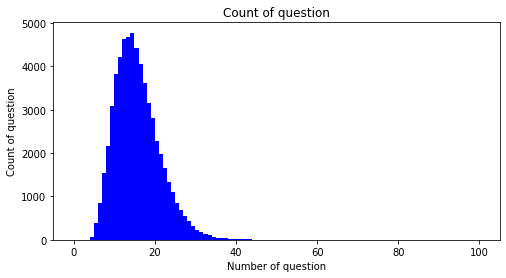

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')

plt.title('Count of question')
plt.xlabel('Number of question')
plt.ylabel('Count of question')
plt.show()

question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50



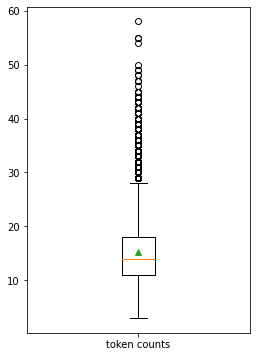

In [ ]:
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")

percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5

print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")
print()

plt.figure(figsize=(4, 6))
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

In [ ]:
contexts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        contexts.append(data["context"])
        if i < 1:
            print(data["context"])

['▁1839', '년', '▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '을', '▁처음', '▁읽고', '▁그', '▁내용에', '▁마음이', '▁끌려', '▁이를', '▁소재로', '▁해서', '▁하나의', '▁교향곡', '을', '▁쓰', '려는', '▁뜻을', '▁갖는다', '.', '▁이', '▁시기', '▁바그너', '는', '▁1838', '년에', '▁빛', '▁독', '촉', '으로', '▁산', '전', '수', '전을', '▁다', '▁', '걲', '은', '▁상황이', '라', '▁좌절', '과', '▁실망', '에', '▁가득', '했으며', '▁메', '피스', '토', '펠', '레스', '를', '▁만나는', '▁', '파우스트', '의', '▁심', '경에', '▁공감', '했다고', '▁한다', '.', '▁또한', '▁파리에서', '▁아브', '네', '크의', '▁지휘', '로', '▁파리', '▁음악원', '▁관현악단', '이', '▁연주하는', '▁베토벤', '의', '▁교향곡', '▁9', '번을', '▁듣고', '▁깊은', '▁감', '명을', '▁받았는데', ',', '▁이것이', '▁이듬해', '▁1', '월에', '▁', '파우스트', '의', '▁서', '곡으로', '▁쓰여진', '▁이', '▁작품에', '▁조금', '이라도', '▁영향을', '▁끼', '쳤', '으리라', '는', '▁것은', '▁의심', '할', '▁여지가', '▁없다', '.', '▁여기', '의', '▁라', '단', '조', '▁조성', '의', '▁경우에도', '▁그의', '▁전기', '에', '▁적혀', '▁있는', '▁것처럼', '▁단순한', '▁정신적', '▁피로', '나', '▁실', '의', '가', '▁반영', '된', '▁것이', '▁아니라', '▁베토벤', '의', '▁합창', '교', '향', '곡', '▁조성', '의', '▁영향을', '▁받은', '▁것을', '▁볼', '▁수', '▁있다'

In [ ]:
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

token을 count한다.

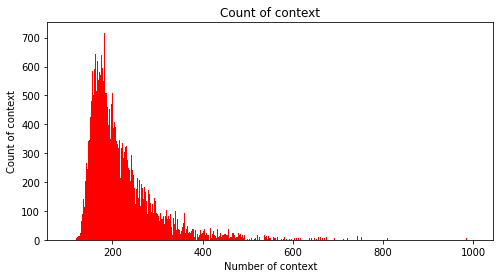

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
plt.title('Count of context')
plt.xlabel('Number of context')
plt.ylabel('Count of context')
plt.show()

context 길이 최대:    4816
context 길이 최소:     108
context 길이 평균:     222.84
context 길이 표준편차:   97.68
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   248.00
context IQR:          79.00
context MAX/100분위:  366.50



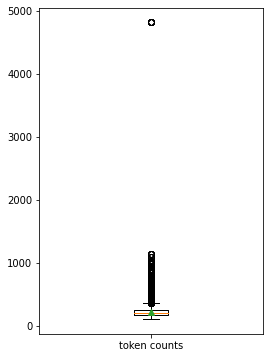

In [ ]:
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")
print(f"context 길이 최소:    {np.min(train_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")

percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5

print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")
print()

plt.figure(figsize=(4, 6))
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

In [ ]:
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], end='  ')

19  168  80  6  143  0  165  216  164  7  

In [ ]:
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

token을 count한다.

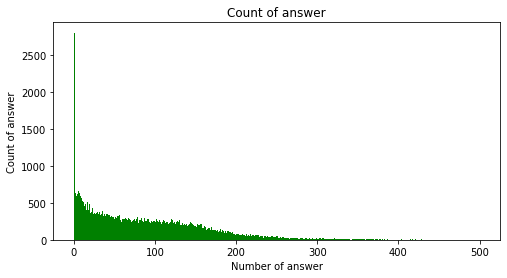

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
plt.title('Count of answer')
plt.xlabel('Number of answer')
plt.ylabel('Count of answer')
plt.show()

answer 위치 최대:    1124
answer 위치 최소:       0
answer 위치 평균:      89.01
answer 위치 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50



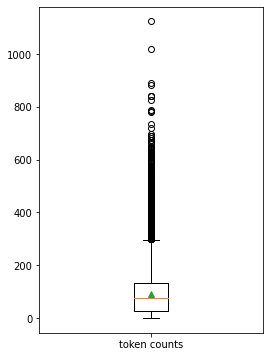

In [ ]:
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")

percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5

print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")
print()

plt.figure(figsize=(4, 6))
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

##Wordcloud

In [ ]:
documents = []

for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

  0%|          | 0/1420 [00:00<?, ?it/s]

train documents를 생성한다.
<br/>전체 데이터에서 title, context, question 문장을 모두 추출한다. 
<br/>

In [ ]:
" ".join(documents[:5])

'파우스트_서곡 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다. 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? 바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가? 바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?'

title, context, question 문장에서 맨 앞 5개만 확인한다.

documents를 전부 이어 하나의 문장으로 만든다.

In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
font = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'

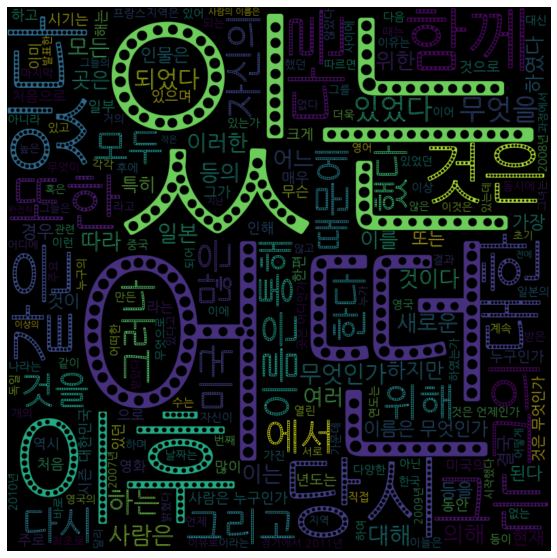

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, font_path = font).generate(" ".join(documents))
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

WordCloud로 " ".join(documents)를 처리한다.
<br/>image 출력, interpolation 이미지 시각화 옵션을 설정한다.

#데이터 로더

In [ ]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [ ]:
class Config(dict):
  
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_query_length': 64, 'max_seq_length': 384}

json을 config 형태로 사용하기 위한 Class이다.
<br/>param dict은 dictionary를 config한다.


In [ ]:
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

생성한 데이터셋 파일을 메모리에 로드하는 함수이다.
<br/>최대 길이내에 token이 들어가지 않은 경우 처리하지 않는다.

In [ ]:
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


훈련 데이터를 로드한다.

In [ ]:
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


평가 데이터를 로드한다.

In [ ]:
train_inputs[:1], 

((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),),)

In [ ]:
train_labels[:1]

(array([ 37, 184,  98, ...,  74, 190,  35]),)

In [ ]:
len(train_inputs[0][0])

384

In [ ]:
train_inputs[0][0][:20]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15])

Question과 Context가 포함된 입력데이터 1번째이다.

In [ ]:
len(train_inputs[1][0])

384

In [ ]:
train_inputs[1][0][0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째이다.

In [ ]:
train_labels[0][0], train_labels[1][0]

(37, 37)

Answer위치의 시작점과 끝점 라벨 1번째이다.

#모델 구성

##Position Embedding

 포지션 임베딩(Position Embedding)은 학습을 통해서 단어의 위치 정보를 얻는다.

###Masked

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

In [ ]:
def get_ahead_mask(tokens, i_pad=0):
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

마스크드 언어 모델은 입력 텍스트의 단어 집합의 15%의 단어를 랜덤으로 마스킹(Masking)한다.
<br/>여기서 마스킹이란 원래의 단어가 무엇이었는지 모르게 한다는 뜻으로
<br/>문장 중간에 구멍을 뚫어놓고, 구멍에 들어갈 단어들을 예측하게 하는 빈칸 채우기 문제로 비유할 수 있다.

In [ ]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

def kernel_initializer(stddev=0.02):
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

def bias_initializer():
    return tf.zeros_initializer

gelu activation 함수를 정의한다.
<br/>parameter initializer를 생성한다.
<br/>bias initializer를 생성한다.

In [ ]:
class Config(dict):
 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

json을 config 형태로 사용하기 위한 Class이다.

###Shared Embedding

In [ ]:
class SharedEmbedding(tf.keras.layers.Layer):
  
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__(name=name)
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    

    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )


    def call(self, inputs, mode="embedding"):

        if mode == "embedding":
            return self._embedding(inputs)
  
        elif mode == "linear":
            return self._linear(inputs)
       
        else:
            raise ValueError(f"mode {mode} is not valid.")
    

    def _embedding(self, inputs):
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed


    def _linear(self, inputs):  
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab]) 
        return outputs

mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스이다. 

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model,
                                                   embeddings_initializer=kernel_initializer())


    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [ ]:
class ScaleDotProductAttention(tf.keras.layers.Layer):

    def __init__(self, name="scale_dot_product_attention"):
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

###MultiHead Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, config, name="multi_head_attention"):

        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head,
                                         kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head,
                                         kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head,
                                         kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
        self.attention = ScaleDotProductAttention(name="self_attention")
        
        self.W_O = tf.keras.layers.Dense(config.d_model,
                                         kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())


    def call(self, Q, K, V, attn_mask):
        
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  
        
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  
        attn_out = self.W_O(attn_out) 

        return attn_out

###Position Wise Feed Forward

In [ ]:
class PositionWiseFeedForward(tf.keras.layers.Layer):

    def __init__(self, config, name="feed_forward"):

        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu,
                                         kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
        self.W_2 = tf.keras.layers.Dense(config.d_model,
                                         kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())


    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

###Encoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, config, name="encoder_layer"):

        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
 
    def call(self, enc_embed, self_mask):

        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

##BERT

In [ ]:
class BERT(tf.keras.layers.Layer):

    def __init__(self, config, name="bert"):

        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)


    def call(self, enc_tokens, segments):
       
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    

    def get_embedding(self, tokens, segments):
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

BERT는 총 3개의 임베딩 층이 사용된다.


WordPiece Embedding Layer는 실질적인 입력이 되는 워드 임베딩을 한다.
<br/>Position Embedding Layer는 위치 정보를 학습하기 위한 임베딩을 한다.
<br/>Segment Embedding Layer는 두 개의 문장을 구분하기 위한 임베딩을 한다.

#Non Pretrained Model

##모델 학습

In [ ]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) 
        start_logits, end_logits = tf.split(hidden, 2, axis=-1) 

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [ ]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024,
                 "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 512,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 8,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007}

In [ ]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [ ]:
model = BERT4KorQuAD(config)

In [ ]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, \
                                    acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')

    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [ ]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [ ]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4) 

best_acc = .0
patience = 0


history = {'train_start_loss': [], 
           'train_end_loss': [], 
           'train_start_acc': [], 
           'train_end_acc': [],
           'val_start_loss': [], 
           'val_end_loss': [],
           'val_start_acc': [], 
           'val_end_acc': []}


for epoch in range(3):
  
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, train_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    history['train_start_loss'].append(start_loss)
    history['train_end_loss'].append(end_loss)
    history['train_start_acc'].append(start_acc)
    history['train_end_acc'].append(end_acc)
    
    train_epoch(model, dev_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    history['val_start_loss'].append(start_loss)
    history['val_end_loss'].append(end_loss)
    history['val_start_acc'].append(start_acc)
    history['val_end_acc'].append(end_acc)

    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience :
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.3281, 5.3638, acc: 0.0021, 0.0010


  0%|          | 0/178 [00:00<?, ?it/s]

eval 0 >> loss: 5.4245, 5.3828, acc: 0.0060, 0.0068
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.6270, 5.6018, acc: 0.0081, 0.0081


  0%|          | 0/178 [00:00<?, ?it/s]

eval 1 >> loss: 5.6475, 5.6402, acc: 0.0074, 0.0095
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.5419, 5.4708, acc: 0.0056, 0.0081


  0%|          | 0/178 [00:00<?, ?it/s]

eval 2 >> loss: 5.5545, 5.4895, acc: 0.0067, 0.0105
save best model


learning rate 5e-4에서 3e-4로 낮추고 Optimzer로 Adam을 사용한다.

훈련 데이터와 검증 데이터에 대한 accuracy와 loss를 구한다.

##인퍼런스


인퍼런스(추론)은 학습을 마친 모델로 실제 과제를 수행하는 행위 혹은 그 과정이다.

학습이 완료된 model을 활용하여 실제 퀴즈 풀이 결과를 확인한다.

In [ ]:
def do_predict(model, question, context):

    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))

    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [ ]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
          if 570 <= i <= 600:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if i > 600:
            break

571
질문 :  동대문 아파트는 몇 층짜리 아파트인가?
지문 :  동대문아파트는 1965년에 완공된 7층짜리 중앙정원형 아파트이다. 대한주택공사가 지은 아파트로 초기에는 연예인들이 많이 살아 "연예인아파트"라는 별명도 있었다. 50년전만 해도 고급아파트였던 동대문아파트는 국내 최초로 중앙정원 방식을 적용했다. 이 방식은 지붕이 없는 형식으로 이후 대한주택공사의 건축의 기본이 된다. 고급아파트를 바로 이때부터 짓기 시작하여 이후에는 정부가 지원하는 외인아파트 시공도 담당한다. 또한 아파트의 고급화를 유지하기 위해 주민들이 물건을 복도에 내놓는 것을 철저히 경비실에서 금지하기도 했다. 1993년 안전진단에서 C등급을 이후 그 뒤로도 계속 중앙정원 굴뚝 부분이 전도될 위험이 있다는 우려가 있었으나 후원기업을 찾아 보강공사를 하여 현재는 B등급으로 남아있다. 서울특별시에 현존하는 아파트 중에 2번째로 오래된 동대문아파트는 충정아파트와 함께 서울속 미래유산 1000선으로 선정하려 하였으나 예산 부족으로 무산되고, 창신동 뉴타운으로 지정하려 하였으나, 이것 역시 무산되었다. 이후 서울특별시는 동대문아파트를 다시 미래유산 후보로 올려 미래유산 아파트로 선정되었다.
정답 :  7층
예측 :  동대문아파트는 1965년에 완공된 7층짜리 중앙정원 

577
질문 :  1967년에 지어진 세운상가를 설계한 사람은?
지문 :  1967년 세운상가가 지어졌다. 세운상가는 세계의 기운을 가진다는 뜻으로, 일제강점기에 공습을 대비하여 소개(疏開)된 지역에 광복 이후 불법 판자촌이 들끓는 것을 보고 당시 불도저시장으로 불리던 김현옥 시장이 주도하여 김수근 건축가가 설계한 대한민국 최초의 주상복합아파트가 탄생하였다. 종로구 종로3가 175-4번지에 있는 세운상가는 당시 재력가나 정부 고위인사 등이 거주하였으며 상가는 1970~1980년대 당시 전자산업의 메카로 불렸다. 삼보컴퓨터가 설립된 곳으로도 유명하다. 세운상가는 강남 개발과 용산전자상가의 설립으로 슬럼화가 진행되어 2008년 서울특

입력에 대한 답변을 생성하는 함수를 정의한다.
<br/>question, context를 입력하여 answer를 생성한다.

#Pretrained Model

##모델 학습

Pretrained Model Finetune은 BERT에 태스크의 데이터를 추가로 학습시켜서 테스트하는 단계이다.

In [ ]:
model = BERT4KorQuAD(config)

In [ ]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

In [ ]:
if os.path.exists(checkpoint_file):
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('No Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_73 (Dense)            multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


checkpoint 파일로부터 필요한 layer를 불러온다. 

In [ ]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4) 

best_acc = .0
patience = 0


history = {'pre_train_start_loss': [], 
           'pre_train_end_loss': [], 
           'pre_train_start_acc': [], 
           'pre_train_end_acc': [],
           'pre_val_start_loss': [], 
           'pre_val_end_loss': [],
           'pre_val_start_acc': [], 
           'pre_val_end_acc': []}


for epoch in range(3):
  
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, train_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    history['pre_train_start_loss'].append(start_loss)
    history['pre_train_end_loss'].append(end_loss)
    history['pre_train_start_acc'].append(start_acc)
    history['pre_train_end_acc'].append(end_acc)
    
    train_epoch(model, dev_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
    history['pre_val_start_loss'].append(start_loss)
    history['pre_val_end_loss'].append(end_loss)
    history['pre_val_start_acc'].append(start_acc)
    history['pre_val_end_acc'].append(end_acc)

    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_new_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience :
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.3441, 5.3433, acc: 0.0066, 0.0075


  0%|          | 0/178 [00:00<?, ?it/s]

eval 0 >> loss: 5.3463, 5.3447, acc: 0.0070, 0.0067
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.3417, 5.3417, acc: 0.0061, 0.0073


  0%|          | 0/178 [00:00<?, ?it/s]

eval 1 >> loss: 5.3334, 5.3373, acc: 0.0065, 0.0070


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.3301, 5.3319, acc: 0.0088, 0.0082


  0%|          | 0/178 [00:00<?, ?it/s]

eval 2 >> loss: 5.3320, 5.3359, acc: 0.0118, 0.0090
save best model


##인퍼런스

In [ ]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
          if 610 < i <= 640 :
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if i > 640:
            break

611
질문 :  여의도 시범아파트는 어떤 형식의 아파트인가?
지문 :  여의도 시범아파트는 대한민국 서울특별시 영등포구 여의도동에 위치한 아파트 단지다. 규모는 1790세대와 24개동이고 1971년 영등포구 여의도동에 지어진 여의도 시범아파트는 국내 첫 민간인 고층아파트이자 대단지이며 최초로 여의도에 지어진 건축물이기도 하다. 건설은 삼부토건, 현대, 부국, 대림, 한국건업, 건설산업, 모양건설이 건축을 맡았다. 이전에도 시범아파트라는 명칭을 가진아파트는 존재했으나 다들 시민아파트의 개량형인 것에 반해 여의도 시범아파트는 최초의 단지형 고층시범아파트로 지어졌다. 당시 건물을 지은 배경을 살펴보면 여의도가 확장공사를 마치어 땅 분양을 하였으나 당시 여의도에 건물을 짓겠다는 사람은 한명도 나오지 않았다. 이로 인해 여의도가 애물단지로 전락하는 것을 막기 위하여 서울시가 시범적으로 여의도에 고층 아파트 단지를 지어 보급한다는 계획을 만들어 1971년 완공되었다. 이후 서울시가 의도한 대로 여의도에 신임을 가진사람들이 늘어 수많은 증권가 건물들이 여의도에 지어졌으며 국회의사당, 국내 방송국 3사 본국과 한화그룹 소유의 63빌딩이 여의도에 지어졌다. 또한 여의도 시범아파트는 가장대표되는 기둥식 아파트로 알려진 바 있으며 역사적 가치로 인해 서울미래문화유산을 지정되기도 했다.
정답 :  기둥식 아파트
예측 :  는 대한민국 서울특별시 영등포구 여의도동에 위치한 아파트 단지다. 규모는 1790세대와 24개동이고 1971년 영등포구 여의도동에 지어진 여의도 시범아파트는 국내 첫 민간인 고층아파트이자 대단지이며 최초로 여의도에 지어진 건축물이기도 하다. 건설은 삼부토건, 현대, 부국, 대림, 한국건업, 건설산업, 모양건설이 건축을 맡았다. 이전에도 시범아파트라는 명칭을 가진아파트는 존재했으나 다들 시민아파트의 개량형인 것에 반해 여의도 시범아파트는 최초의 단지형 고층시범아파트로 지어졌다. 당시 건물을 지은 배경을 살펴보면 여의도가 확장공사를 마치어 땅 분양을 하였으나 당시 

#모델 평가

pretrained model 사용 여부에 따라 학습 수행 경과가 어떻게 달라지는지를
<br/>시각화를 포함하여 비교 분석을 진행한다.

Text(0.5, 1.0, 'end-accuracy')

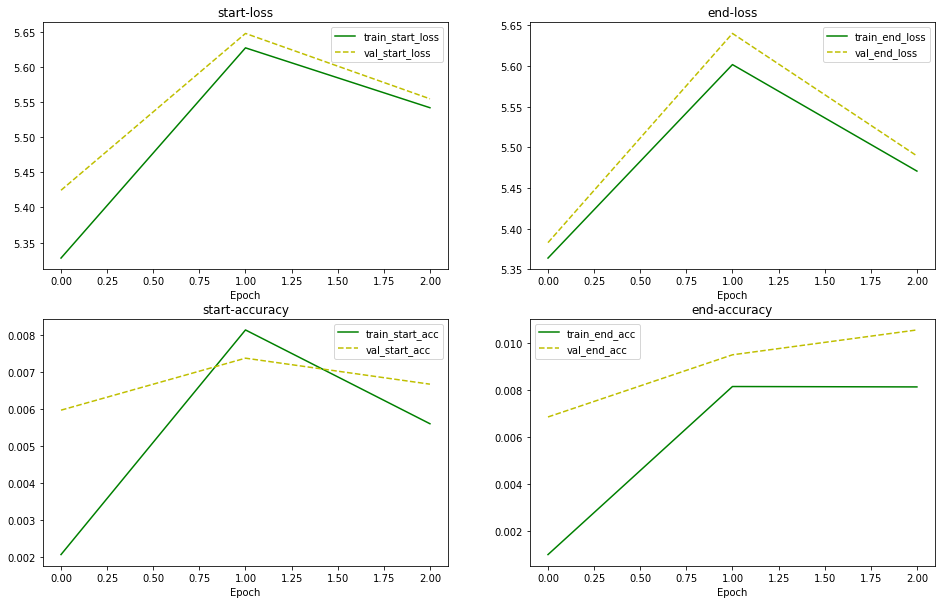

In [ ]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(history['train_start_loss'], 'g-', label='train_start_loss')
plt.plot(history['val_start_loss'], 'y--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('start-loss')

plt.subplot(2, 2, 2)
plt.plot(history['train_end_loss'], 'g-', label='train_end_loss')
plt.plot(history['val_end_loss'], 'y--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('end-loss')

plt.subplot(2, 2, 3)
plt.plot(history['train_start_acc'], 'g-', label='train_start_acc')
plt.plot(history['val_start_acc'], 'y--', label='val_start_acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('start-accuracy')


plt.subplot(2, 2, 4)
plt.plot(history['train_end_acc'], 'g-', label='train_end_acc')
plt.plot(history['val_end_acc'], 'y--', label='val_end_acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('end-accuracy')


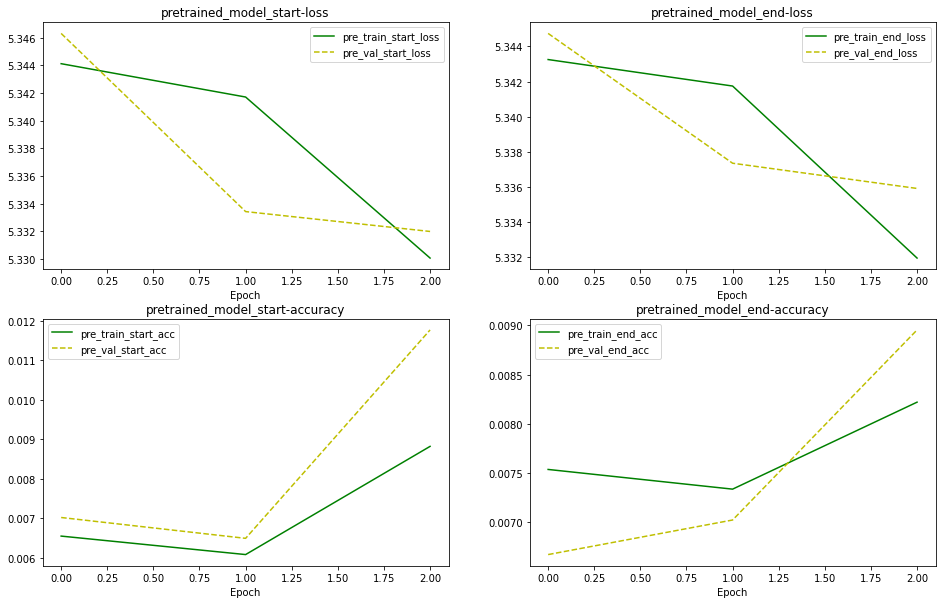

In [ ]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(history['pre_train_start_loss'], 'g-', label='pre_train_start_loss')
plt.plot(history['pre_val_start_loss'], 'y--', label='pre_val_start_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('pretrained_model_start-loss')

plt.subplot(2, 2, 2)
plt.plot(history['pre_train_end_loss'], 'g-', label='pre_train_end_loss')
plt.plot(history['pre_val_end_loss'], 'y--', label='pre_val_end_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('pretrained_model_end-loss')

plt.subplot(2, 2, 3)
plt.plot(history['pre_train_start_acc'], 'g-', label='pre_train_start_acc')
plt.plot(history['pre_val_start_acc'], 'y--', label='pre_val_start_acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('pretrained_model_start-accuracy')

plt.subplot(2, 2, 4)
plt.plot(history['pre_train_end_acc'], 'g-', label='pre_train_end_acc')
plt.plot(history['pre_val_end_acc'], 'y--', label='pre_val_end_acc')
plt.xlabel('Epoch')
plt.legend()
plt.title('pretrained_model_end-accuracy')

plt.show()

#결론

앞으로 NLP 모델을 공부하면서 코드에 대한 설명을 추가할 예정이다.
<br/>밑바닥부터 시작한 딥러닝 2권 1회독을 하고 1차 수정을 한다.
<br/>구글 BERT의 정석 1회독을 하고 2차 수정을 한다.
<br/>BERT : Pre-training of deep bidirectional transformers for language understanding
<br/>논문을 정독하고 3차 수정을 한다.
<br/>그리고 KorQuAD 모델의 validation accuracy가 안정적으로 증가하고
<br/> 원래의 정답과 유사한 인퍼런스 결과가 출력되게 한다.


#참고문헌

**LMS**
<br/>[cchyun](https://github.com/paul-hyun)

<br/>**단행본**
<br/>유원준 외 1명, 딥러닝을 이용한 자연어 처리 입문, wikidocs, 2022
<br/>[NLP에서의 사전 훈련(Pre-training)](https://wikidocs.net/108730)
<br/>[버트(Bidirectional Encoder Representations from Transformers, BERT)](https://wikidocs.net/115055)

<br/>**깃허브**
<br/>[KorQuAD Task using BERT.ipynb](https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E26.KorQuAD%20Task%20using%20BERT.ipynb)
<br/>[KorQuAD_BERT.ipynb](https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BE-19%5DKorQuAD_BERT.ipynb)

<br/>**웹사이트**
<br/>[인공지능 퀴즈 풀기|KorQuAD_BERT](https://zzcojoa.tistory.com/91)
<br/>[학습 마친 모델을 실전 투입하기](https://ratsgo.github.io/nlpbook/docs/ner/inference/)